# Train a gesture recognition model for microcontroller (ESP32) use

This notebook demonstrates how to train a 20kb gesture recognition model for [TensorFlow Lite for Microcontrollers](https://tensorflow.org/lite/microcontrollers/overview). It will produce the same model used in the [magic_wand_esp32_mpu6050](https://github.com/stefan/MagicWand-TFLite-ESP32-MPU6050/blob/main/magic_wand_esp32_mpu6050) application.

The model is designed to be used with [Google Colaboratory](https://colab.research.google.com).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/stefan-spiss/MagicWand-TFLite-ESP32-MPU6050/blob/main/train/train_magic_wand_model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/stefan-spiss/MagicWand-TFLite-ESP32-MPU6050/blob/main/train/train_magic_wand_model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


Training is much faster using GPU acceleration. Before you proceed, ensure you are using a GPU runtime by going to **Runtime -> Change runtime type** and selecting **GPU**. Training will take around 5 minutes on a GPU runtime.

## Configure dependencies

Run the following cell to ensure the correct version of TensorFlow is used.

We'll also clone the TensorFlow repository, which contains the training scripts, and copy them into our workspace.

In [1]:
# Clone the repository from GitHub
!git clone --depth 1 -q https://github.com/stefan-spiss/MagicWand-TFLite-ESP32-MPU6050.git
# Copy the training scripts into our workspace
!cp -r MagicWand-TFLite-ESP32-MPU6050/train train

## Prepare the data

Next, we'll extract the data into the expected location within the training scripts' directory.

In [2]:
# Extract the data into the train directory
!unzip  MagicWand-TFLite-ESP32-MPU6050/data/data.zip -d train
#!tar xvzf data.tar.gz -C train 1>/dev/null

Archive:  MagicWand-TFLite-ESP32-MPU6050/data/data.zip
   creating: train/data/
   creating: train/data/negative/
  inflating: train/data/negative/output_negative_Elekas.txt  
  inflating: train/data/negative/output_negative_arthur.txt  
  inflating: train/data/negative/output_negative_filip.txt  
  inflating: train/data/negative/output_negative_kai.txt  
  inflating: train/data/negative/output_negative_lukas.txt  
  inflating: train/data/negative/output_negative_nico.txt  
  inflating: train/data/negative/output_negative_peter.txt  
  inflating: train/data/negative/output_negative_stefan.txt  
  inflating: train/data/negative/output_negative_yeongmi.txt  
   creating: train/data/ring/
  inflating: train/data/ring/output_ring_Elekas.txt  
  inflating: train/data/ring/output_ring_alex.txt  
  inflating: train/data/ring/output_ring_arthur.txt  
  inflating: train/data/ring/output_ring_filip.txt  
  inflating: train/data/ring/output_ring_justin.txt  
  inflating: train/data/ring/output_ri

We now inspect the data by plotting it.

/content/train
not enough negative samples available, creating random data samples


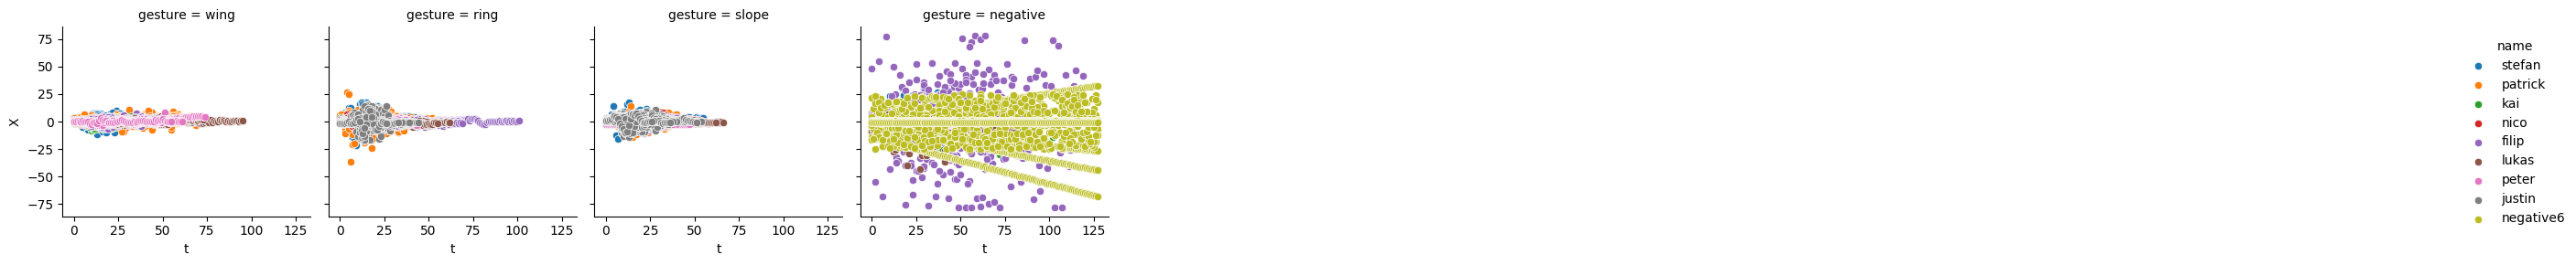

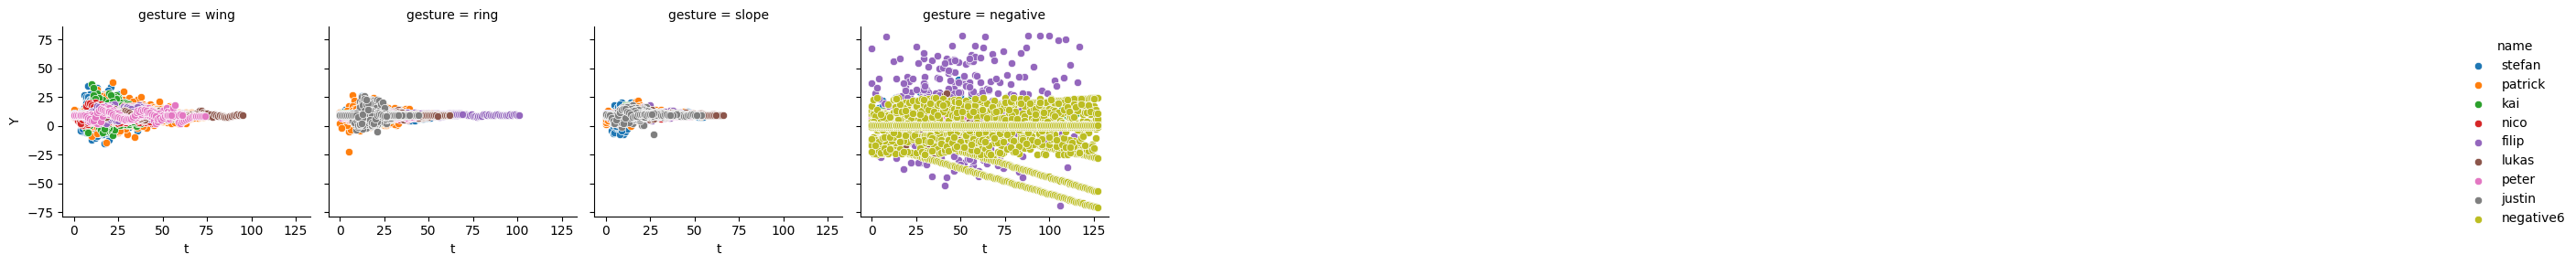

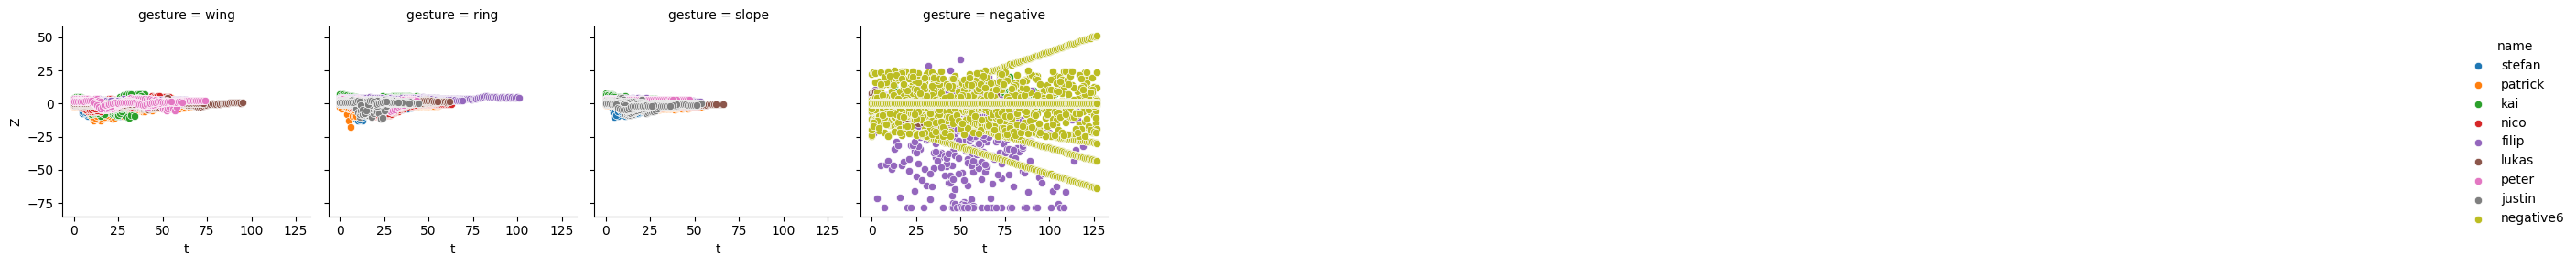

In [3]:
# The scripts must be run from within the train directory
%cd train
# Plot the data
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import numpy as np
import math

from data_prepare import prepare_original_data
from data_prepare import generate_negative_data

LABEL_NAME = "gesture"
DATA_NAME = "accel_ms2_xyz"
folders = ["wing", "ring", "slope"]
names = [
    "stefan",
    "patrick",
    "justin",
    "yeongmi"
    "arthur",
    "kai",
    "nico",
    "filip",
    "lukas",
    "peter",
]

data = []  # pylint: disable=redefined-outer-name
for idx1, folder in enumerate(folders):
  for idx2, name in enumerate(names):
    prepare_original_data(folder, name, data,
                          "./data/%s/output_%s_%s.txt" % (folder, folder, name))
n_gestures = len(data)
for idx, name in enumerate(names):
  prepare_original_data("negative", name, data,
                        "./data/negative/output_negative_%s.txt" % (name))
n_negative = len(data) - n_gestures
folders.append("negative")

# if there are more than 10% more gesture samples per gesture as negative samples, generate additional negative
# samples
if n_gestures - n_negative * len(folders) > n_gestures/len(folders) * 0.1:
  print("not enough negative samples available, creating random data samples")
  generate_negative_data(data, (math.ceil(n_gestures/len(folders)) - n_negative))
n_negative = len(data) - n_gestures

columns = [LABEL_NAME, "name", DATA_NAME]
df = pd.DataFrame(data, columns=columns)

df_gesture_data = pd.DataFrame()
for folder in folders:
  for row in df.loc[df[LABEL_NAME] == folder].iterrows():
    tmp_data = np.array(row[1][DATA_NAME])
    df_tmp = pd.DataFrame({
      "name": np.full(len(tmp_data), row[1]["name"]),
      LABEL_NAME: np.full(len(tmp_data), folder),
      "t": range(len(tmp_data)),
      "X": tmp_data[:, 0],
      "Y": tmp_data[:, 1],
      "Z": tmp_data[:, 2]
      })
    df_gesture_data = pd.concat([df_gesture_data, df_tmp], ignore_index=True)

# print(df_gesture_data)
# sb.scatterplot(data = df_gesture_data, x = "t", y = "X", col)
# for folder in folders:
#   grid_X = sb.FacetGrid(df_gesture_data.loc[df_gesture_data[LABEL_NAME] == folder], col = "name", hue = LABEL_NAME, col_wrap=3)
#   grid_X.map(sb.scatterplot, "t", "X")
#   grid_X.add_legend()
#   grid_Y = sb.FacetGrid(df_gesture_data.loc[df_gesture_data[LABEL_NAME] == folder], col = "name", hue = LABEL_NAME, col_wrap=3)
#   grid_Y.map(sb.scatterplot, "t", "Y")
#   grid_Y.add_legend()
#   grid_Z = sb.FacetGrid(df_gesture_data.loc[df_gesture_data[LABEL_NAME] == folder], col = "name", hue = LABEL_NAME, col_wrap=3)
#   grid_Z.map(sb.scatterplot, "t", "Z")
#   grid_Z.add_legend()

grid_X = sb.FacetGrid(df_gesture_data, col = LABEL_NAME, hue = "name", col_wrap=len(names))
grid_X.map(sb.scatterplot, "t", "X")
grid_X.add_legend()
grid_Y = sb.FacetGrid(df_gesture_data, col = LABEL_NAME, hue = "name", col_wrap=len(names))
grid_Y.map(sb.scatterplot, "t", "Y")
grid_Y.add_legend()
grid_Z = sb.FacetGrid(df_gesture_data, col = LABEL_NAME, hue = "name", col_wrap=len(names))
grid_Z.map(sb.scatterplot, "t", "Z")
grid_Z.add_legend()

plt.show()

We'll then run the scripts that split the data into training, validation, and test sets.

In [4]:
# Prepare the data
!python data_prepare.py
# Split the data by person
#!python data_split_person.py
# Split the data randomly since only one person available
!python data_split.py

not enough negative samples available, creating random data samples
gesture_data_length: 429
negative_data_length: 142
data_length: 571
data_length:571
{'wing': 127, 'ring': 151, 'slope': 151, 'negative': 142}
train_length:341
test_length:117


In [5]:
################################ DEBUG: check files
%cd data
%ls -l

total 100
drwxr-xr-x 6 root root  4096 Dec  5 05:49 data/
-rw-r--r-- 1 root root  2889 Dec  5 05:48 data_augmentation.py
-rw-r--r-- 1 root root  2096 Dec  5 05:48 data_augmentation_test.py
-rw-r--r-- 1 root root  4173 Dec  5 05:48 data_load.py
-rw-r--r-- 1 root root  4213 Dec  5 05:48 data_load_test.py
-rw-r--r-- 1 root root  3490 Dec  5 05:48 data_plot.py
-rw-r--r-- 1 root root  5995 Dec  5 05:48 data_prepare.py
-rw-r--r-- 1 root root  2813 Dec  5 05:48 data_prepare_test.py
-rw-r--r-- 1 root root  2878 Dec  5 05:48 data_split_person.py
-rw-r--r-- 1 root root  1905 Dec  5 05:48 data_split_person_test.py
-rw-r--r-- 1 root root  3071 Dec  5 05:48 data_split.py
-rw-r--r-- 1 root root  3141 Dec  5 05:48 data_split_test.py
drwxr-xr-x 2 root root  4096 Dec  5 05:48 __pycache__/
-rw-r--r-- 1 root root  3624 Dec  5 05:48 README.md
-rw-r--r-- 1 root root    32 Dec  5 05:48 requirements.txt
-rw-r--r-- 1 root root 11296 Dec  5 05:48 train_magic_wand_model.ipynb
-rw-r--r-- 1 root root  8654 Dec  5

## Load TensorBoard

Now, we set up TensorBoard so that we can graph our accuracy and loss as training proceeds.

In [ ]:
# Load TensorBoard
%load_ext tensorboard
%tensorboard --logdir logs/scalars

## Begin training

The following cell will begin the training process. Training will take around 5 minutes on a GPU runtime. You'll see the metrics in TensorBoard after a few epochs.

In [ ]:
#!python train.py --model CNN --person true
!python train.py --model CNN

## Create a C source file

The `train.py` script writes a model, `model.tflite`, to the training scripts' directory.

In the following cell, we convert this model into a C++ source file we can use with TensorFlow Lite for Microcontrollers.

In [ ]:
# Install xxd if it is not available
!apt-get -qq install xxd
# Save the file as a C source file
!xxd -i model.tflite > /content/model.cc
# Print the source file
!cat /content/model.cc